In [43]:
def griddata_inter(X1,X2,X3,point,xi,yi,Ozone,Aot,Raa):
    X1_new_inter=[]
    X2_new_inter=[]
    X3_new_inter=[]

    X1_inter=X1[Ozone,Aot,:,:,Raa].reshape(17*17,1)
    X2_inter=X2[Ozone,Aot,:,:,Raa].reshape(17*17,1)
    X3_inter=X3[Ozone,Aot,:,:,Raa].reshape(17*17,1)

    X1_new = griddata(point, X1_inter, (xi, yi), method='cubic')
    X2_new = griddata(point, X2_inter, (xi, yi), method='cubic')
    X3_new = griddata(point, X3_inter, (xi, yi), method='cubic')

    X1_new_inter.append(X1_new)
    X2_new_inter.append(X2_new)
    X3_new_inter.append(X3_new)

    del X1_inter,X2_inter,X3_inter,X1_new,X2_new,X3_new  
    return X1_new_inter,X2_new_inter,X3_new_inter

class LUT_interpolation:
    def __init__(self,LUT_path):
        self.LUT_path = LUT_path
    
    def LUT_interpolation(self):
#         Continental_X1 = np.loadtxt(self.LUT_path + "Continental_01_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
#         Continental_X2 = np.loadtxt(self.LUT_path + "Continental_02_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
#         Continental_X3 = np.loadtxt(self.LUT_path + "Continental_03_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
        
        X1 = np.loadtxt(self.LUT_path + "Maritime_01_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "Maritime_02_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "Maritime_03_band1.csv",delimiter=",").reshape(5,12,17,17,19)

        
#         del Continental_X1,Maritime_X1,Continental_X2,Maritime_X2,Continental_X3,Maritime_X3
        

        
        point = np.array(np.meshgrid(sza, vza)).T.reshape(-1,2)
        xi,yi=np.ogrid[0:80:161j, 0:80:161j]
        output = Parallel(n_jobs=-1)(delayed(griddata_inter)(X1,X2,X3,point,xi,yi,Ozone,Aot,Raa)\
                                         for Ozone in range(len(ozone))                              
                                         for Aot in range(len(AOT))                              
                                         for Raa in range(len(raa)))

        X1_new_inter_reshape=np.array(output)[:,0].reshape(5,12,19,161,161)
        X2_new_inter_reshape=np.array(output)[:,1].reshape(5,12,19,161,161)
        X3_new_inter_reshape=np.array(output)[:,2].reshape(5,12,19,161,161)

        del X1,X2,X3,output

        sza_new = np.linspace(0,80,161)
        vza_new = np.linspace(0,80,161)

        fn1 = RegularGridInterpolator((ozone,AOT,raa,sza_new,vza_new),X1_new_inter_reshape,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((ozone,AOT,raa,sza_new,vza_new),X2_new_inter_reshape,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((ozone,AOT,raa,sza_new,vza_new),X3_new_inter_reshape,bounds_error=False,fill_value=np.nan)

        return fn1,fn2,fn3

In [2]:
import numpy as np
from Py6S import *
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import multiprocessing
import paramiko
from scp import SCPClient
import subprocess

/opt/conda/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [25]:
sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
LUT_path = 'LUT/'

In [44]:
fn1,fn2,fn3 = LUT_interpolation(LUT_path).LUT_interpolation()

In [27]:
OZONE = np.random.uniform(0.2,0.4,1000)
WATER = np.random.uniform(0,7,1000)
aot = np.random.uniform(0.01,2,1000)
SZA = np.random.uniform(0,80,1000)
VZA = np.random.uniform(0,80,1000)
RAA = np.random.uniform(0,180,1000)


In [47]:
xa_LUT = []
xb_LUT = []
xc_LUT = []

for i in range(1000):
    xi = np.array([OZONE[i],aot[i],RAA[i],SZA[i],VZA[i]])
    xi = xi.T
    xa_LUT.append(fn1(xi))
    xb_LUT.append(fn2(xi))
    xc_LUT.append(fn3(xi))
    
xa_LUT = np.array(xa_LUT)
xb_LUT = np.array(xb_LUT)
xc_LUT = np.array(xc_LUT)

In [10]:

def sixS(i):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(3,OZONE[i])
    s.aero_profile = AeroProfile.PredefinedType(2)
    s.aot550 = aot[i]
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = SZA[i]
    s.geometry.solar_a = RAA[i]
    s.geometry.view_z = VZA[i]
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [29]:
wl_band = "sixs_band1.csv"
band = np.loadtxt(wl_band,delimiter=",")
AC_output = Parallel(n_jobs=-1)(delayed(sixS)(i) \
                                for i in range (1000))

In [30]:
X=np.array(AC_output)
X1=X[:,0]
X2=X[:,1]
X3=X[:,2]

In [17]:

class LUT_interpolation:
    def __init__(self,LUT_path):
        self.LUT_path = LUT_path
    
    def LUT_interpolation_Linear(self):
        
        X1 = np.loadtxt(self.LUT_path + "Maritime_01_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "Maritime_02_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "Maritime_03_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        

        fn1 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan,method='linear')
        fn2 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan,method='linear')
        fn3 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan,method='linear')

        return fn1,fn2,fn3
    def LUT_interpolation_Nearest(self):
        
        X1 = np.loadtxt(self.LUT_path + "Maritime_01_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "Maritime_02_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "Maritime_03_band1.csv",delimiter=",").reshape(5,12,17,17,19)
        

        fn1 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan,method='nearest')
        fn2 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan,method='nearest')
        fn3 = RegularGridInterpolator((ozone,AOT,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan,method='nearest')

        return fn1,fn2,fn3
    

fn1_L,fn2_L,fn3_L = LUT_interpolation(LUT_path).LUT_interpolation_Linear()
fn1_N,fn2_N,fn3_N = LUT_interpolation(LUT_path).LUT_interpolation_Nearest()



In [31]:
xa_LUT_N = []
xb_LUT_N = []
xc_LUT_N = []

for i in range(1000):
    xi = np.array([OZONE[i],aot[i],SZA[i],VZA[i],RAA[i]])
    xi = xi.T
    xa_LUT_N.append(fn1_N(xi))
    xb_LUT_N.append(fn2_N(xi))
    xc_LUT_N.append(fn3_N(xi))
    
xa_LUT_N = np.array(xa_LUT_N)
xb_LUT_N= np.array(xb_LUT_N)
xc_LUT_N = np.array(xc_LUT_N)

xa_LUT_L = []
xb_LUT_L = []
xc_LUT_L = []

for i in range(1000):
    xi = np.array([OZONE[i],aot[i],SZA[i],VZA[i],RAA[i]])
    xi = xi.T
    xa_LUT_L.append(fn1_L(xi))
    xb_LUT_L.append(fn2_L(xi))
    xc_LUT_L.append(fn3_L(xi))
    
xa_LUT_L = np.array(xa_LUT_L)
xb_LUT_L= np.array(xb_LUT_L)
xc_LUT_L = np.array(xc_LUT_L)

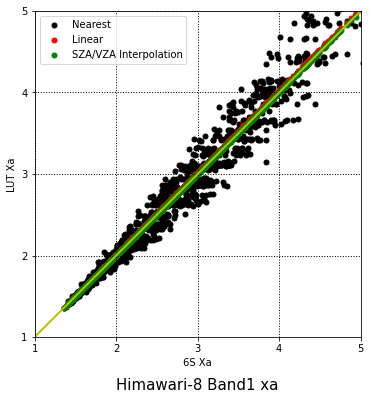

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

xx = np.arange(1,6) 

r2_N = r2_score(X1, xa_LUT_N)
r2_N = np.around(r2_N,4)
k_N = np.polyfit(X1, xa_LUT_N,1)[0][0]
b_N = np.polyfit(X1, xa_LUT_N,1)[1][0]
k_N = np.around(k_N,4)
b_N = np.around(b_N,4)
yy_N = k_N * xx + b_N

r2_L = r2_score(X1, xa_LUT_L)
r2_L = np.around(r2_L,4)
k_L = np.polyfit(X1, xa_LUT_L,1)[0][0]
b_L = np.polyfit(X1, xa_LUT_L,1)[1][0]
k_L = np.around(k_L,4)
b_L = np.around(b_L,4)
yy_L = k_L * xx + b_L

r2 = r2_score(X1, xa_LUT)
r2 = np.around(r2,4)

k = np.polyfit(X1, xa_LUT,1)[0][0]
b = np.polyfit(X1, xa_LUT,1)[1][0]
k = np.around(k,4)
b = np.around(b,4)
xx = np.arange(1,6) 
yy = k * xx + b



x = np.arange(1,6)
y = 1 * x
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(xx,yy_N,color='k',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy_L,color='r',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy,color='g',linewidth=3,linestyle='-',zorder=2)


ax.scatter(X1, xa_LUT_N,marker='o',s=25,c='k',label='Nearest')
ax.scatter(X1, xa_LUT_L,marker='o',s=25,c='r',label='Linear')
ax.scatter(X1, xa_LUT,marker='o',s=25,c='g',label='SZA/VZA Interpolation')


ax.set_xticks(np.arange(1,6,1))
ax.set_yticks(np.arange(1,6,1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xa",fontsize=10)
ax.set_ylabel("LUT Xa",fontsize=10)

ax.plot(x,y,color='y',linewidth=2,linestyle='-',zorder=2)

# ax.text(1.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
# ax.text(1.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)

plt.xlim(1,5)
plt.ylim(1,5)
plt.title('Himawari-8 Band1 xa',fontsize=15,y=-0.18)
plt.legend()
plt.show()
fig.savefig('LUT_xa_B01_L.jpg',dpi = 1000,bbox_inches = 'tight')

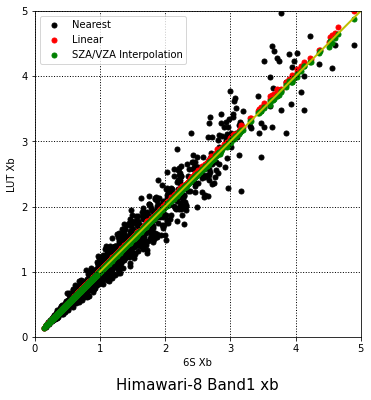

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# xx = np.arange(1,6) 

# r2_N = r2_score(X1, xa_LUT_N)
# r2_N = np.around(r2_N,4)
# k_N = np.polyfit(X1, xa_LUT_N,1)[0][0]
# b_N = np.polyfit(X1, xa_LUT_N,1)[1][0]
# k_N = np.around(k_N,4)
# b_N = np.around(b_N,4)
# yy_N = k_N * xx + b_N

# r2_L = r2_score(X1, xa_LUT_L)
# r2_L = np.around(r2,4)
# k_L = np.polyfit(X1, xa_LUT_L,1)[0][0]
# b_L = np.polyfit(X1, xa_LUT_L,1)[1][0]
# k_L = np.around(k,4)
# b_L = np.around(b,4)
# yy_L = k_L * xx + b_L

# r2 = r2_score(X1, xa_LUT)
# r2 = np.around(r2,4)

# k = np.polyfit(X1, xa_LUT,1)[0][0]
# b = np.polyfit(X1, xa_LUT,1)[1][0]
# k = np.around(k,4)
# b = np.around(b,4)
# xx = np.arange(1,6) 
# yy = k * xx + b



x = np.arange(1,6)
y = 1 * x
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(xx,yy_N,color='k',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy_L,color='r',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy,color='g',linewidth=3,linestyle='-',zorder=2)


ax.scatter(X2, xb_LUT_N,marker='o',s=25,c='k',label='Nearest')
ax.scatter(X2, xb_LUT_L,marker='o',s=25,c='r',label='Linear')
ax.scatter(X2, xb_LUT,marker='o',s=25,c='g',label='SZA/VZA Interpolation')


ax.set_xticks(np.arange(0,6,1))
ax.set_yticks(np.arange(0,6,1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xb",fontsize=10)
ax.set_ylabel("LUT Xb",fontsize=10)

ax.plot(x,y,color='y',linewidth=2,linestyle='-',zorder=2)

# ax.text(1.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
# ax.text(1.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)

plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Himawari-8 Band1 xb',fontsize=15,y=-0.18)
plt.legend()
plt.show()
fig.savefig('LUT_xb_B01_L.jpg',dpi = 1000,bbox_inches = 'tight')

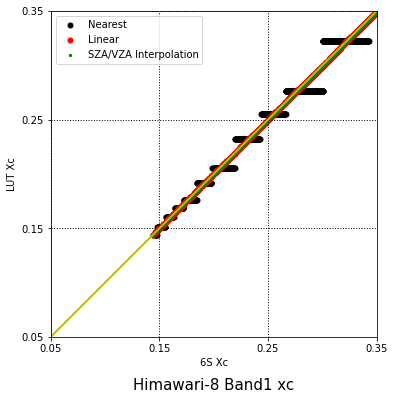

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# xx = np.arange(1,6) 

# r2_N = r2_score(X1, xa_LUT_N)
# r2_N = np.around(r2_N,4)
# k_N = np.polyfit(X1, xa_LUT_N,1)[0][0]
# b_N = np.polyfit(X1, xa_LUT_N,1)[1][0]
# k_N = np.around(k_N,4)
# b_N = np.around(b_N,4)
# yy_N = k_N * xx + b_N

# r2_L = r2_score(X1, xa_LUT_L)
# r2_L = np.around(r2,4)
# k_L = np.polyfit(X1, xa_LUT_L,1)[0][0]
# b_L = np.polyfit(X1, xa_LUT_L,1)[1][0]
# k_L = np.around(k,4)
# b_L = np.around(b,4)
# yy_L = k_L * xx + b_L

# r2 = r2_score(X1, xa_LUT)
# r2 = np.around(r2,4)

# k = np.polyfit(X1, xa_LUT,1)[0][0]
# b = np.polyfit(X1, xa_LUT,1)[1][0]
# k = np.around(k,4)
# b = np.around(b,4)
# xx = np.arange(1,6) 
# yy = k * xx + b



x = np.arange(0.05,0.36,0.1)
y = 1 * x
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(xx,yy_N,color='k',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy_L,color='r',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy,color='g',linewidth=3,linestyle='-',zorder=2)


ax.scatter(X3, xc_LUT_N,marker='o',s=25,c='k',label='Nearest')
ax.scatter(X3, xc_LUT_L,marker='o',s=25,c='r',label='Linear')
ax.scatter(X3, xc_LUT,marker='o',s=5,c='g',label='SZA/VZA Interpolation')


ax.set_xticks(np.arange(0.05,0.36,0.1))
ax.set_yticks(np.arange(0.05,0.36,0.1))

ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xc",fontsize=10)
ax.set_ylabel("LUT Xc",fontsize=10)

ax.plot(x,y,color='y',linewidth=2,linestyle='-',zorder=2)

# ax.text(1.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
# ax.text(1.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)

plt.xlim(0.05,0.35)
plt.ylim(0.05,0.35)

plt.title('Himawari-8 Band1 xc',fontsize=15,y=-0.18)
plt.legend()
plt.show()
fig.savefig('LUT_xc_B01_L.jpg',dpi = 1000,bbox_inches = 'tight')

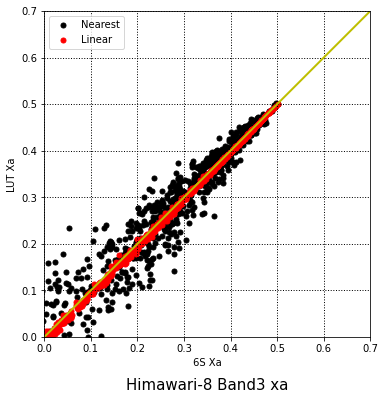

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

xx = np.arange(1,6) 

# r2_N = r2_score(X1, xa_LUT_N)
# r2_N = np.around(r2_N,4)
# k_N = np.polyfit(X1, xa_LUT_N,1)[0][0]
# b_N = np.polyfit(X1, xa_LUT_N,1)[1][0]
# k_N = np.around(k_N,4)
# b_N = np.around(b_N,4)
# yy_N = k_N * xx + b_N

# r2_L = r2_score(X1, xa_LUT_L)
# r2_L = np.around(r2_L,4)
# k_L = np.polyfit(X1, xa_LUT_L,1)[0][0]
# b_L = np.polyfit(X1, xa_LUT_L,1)[1][0]
# k_L = np.around(k_L,4)
# b_L = np.around(b_L,4)
# yy_L = k_L * xx + b_L

# r2 = r2_score(X1, xa_LUT)
# r2 = np.around(r2,4)

# k = np.polyfit(X1, xa_LUT,1)[0][0]
# b = np.polyfit(X1, xa_LUT,1)[1][0]
# k = np.around(k,4)
# b = np.around(b,4)
# xx = np.arange(1,6) 
# yy = k * xx + b



x = np.arange(0,1.1,0.1)
y = 1 * x
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(xx,yy_N,color='k',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy_L,color='r',linewidth=3,linestyle='-',zorder=2)
# ax.plot(xx,yy,color='g',linewidth=3,linestyle='-',zorder=2)



ax.scatter((X1*0.5 - X2) / (1+X3*(X1*0.5 - X2)), (xa_LUT_N*0.5 - xb_LUT_N) / (1+xc_LUT_N*(xa_LUT_N*0.5 - xb_LUT_N)),marker='o',s=25,c='k',label='Nearest')
ax.scatter((X1*0.5 - X2) / (1+X3*(X1*0.5 - X2)), (xa_LUT_L*0.5 - xb_LUT_L) / (1+xc_LUT_L*(xa_LUT_L*0.5 - xb_LUT_L)),marker='o',s=25,c='r',label='Linear')
# ax.scatter((X1*0.5 - X2) / (1+X3*(X1*0.5 - X2)), (xa_LUT*0.5 - xb_LUT) / (1+xc_LUT*(xa_LUT*0.5 - xb_LUT)),marker='o',s=25,c='g',label='SZA/VZA Interpolation')


ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xa",fontsize=10)
ax.set_ylabel("LUT Xa",fontsize=10)

ax.plot(x,y,color='y',linewidth=2,linestyle='-',zorder=2)

# ax.text(1.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
# ax.text(1.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)

plt.xlim(0,0.7)
plt.ylim(0,0.7)
plt.title('Himawari-8 Band3 xa',fontsize=15,y=-0.18)
plt.legend()
plt.show()
# fig.savefig('LUT_xa_B03_L.jpg',dpi = 1000,bbox_inches = 'tight')